# Exploring Inconsistancies Between AllStatesAndTerritories Files

This notebook explores inconsistancies in the *LESO Property Transferred to Participating Agencies* files that are published quarterly on the [DLA LESO Public Data](https://www.dla.mil/DispositionServices/Offers/Reutilization/LawEnforcement/PublicInformation/) website. As of October 2020, three DISP_AllStatesAndTransfers files have been collected for the quarters ending March 31, June 30 and September 30 of 2020.

In [1]:
#    Libraries used by this notebook.

import pandas as pd
import matplotlib.pyplot as plt
import sys

from IPython.display import Markdown as md

#!python --version    #Python 3.8.5
# sys standard module
#!jupyter --version
# ipython             #ipython 7.18.1
#pd.__version__       #1.1.2

sys.path.insert(0, "..\\..\\scripts\\") # go to parent dir
from notebookfunctions import make_dataframe
from notebookfunctions import count_by_time
from notebookfunctions import differences_by_time
from notebookfunctions import split_demilcodes

#    VARIABLES THAT CAN BE CUSTOMIZED

#    Enter the path to the folder containing all the data files.
path_datafiles = "../../data/"

#    Get the 'LESO Property Transferred to Participating Agencies' file from 
#        Defense Logicstics Agency Law Enforcement Support Office Public Information
#    The original name of the data file should be in the form:
#        DISP_AllStatesAndTerritories_mmddyyyy.xlsx  
#
#    Enter the name of the LESO files to be checked.
LESO1_file = "DISP_AllStatesAndTerritories_03312020.xlsx"
LESO2_file = "DISP_AllStatesAndTerritories_06302020.xlsx"
LESO3_file = "DISP_AllStatesAndTerritories_09302020.xlsx"
#LESO4_file = "DISP_AllStatesAndTerritories_12312020.xlsx"

#    Read the data from the XLSX files.
#    transfer#_dict is a dictionary of all sheets in the LESO_file
#         keys are full state/territory names
#         values are a single dataframe of all transfers for that state/territory
#    The records may be cumulative up to this quarter.
transfers1_dict = pd.read_excel('file:' + path_datafiles + LESO1_file, sheet_name=None)
transfers2_dict = pd.read_excel('file:' + path_datafiles + LESO2_file, sheet_name=None)
transfers3_dict = pd.read_excel('file:' + path_datafiles + LESO3_file, sheet_name=None)
#transfers4_dict = pd.read_excel('file:' + path_datafiles + LESO4_file, sheet_name=None)

#    Flatten each dictionary of states into its own dataframe
transfers1_df = make_dataframe(transfers1_dict, 'Ship Date')
transfers2_df = make_dataframe(transfers2_dict, 'Ship Date')
transfers3_df = make_dataframe(transfers3_dict, 'Ship Date')
#transfers4_df = make_dataframe(transfers4_dict, 'Ship Date')

#    Temporary way to track files the notebook is working with
file_quarters_dict = {'transfers1': (transfers1_df, 'Quarter 1'),
                      'transfers2': (transfers2_df, 'Quarter 2'),
                      'transfers3': (transfers3_df, 'Quarter 3')}

### What is the range of dates on records in each file?

Under the section called *LESO Property Transferred to Participating Agencies*, the DLA LESO Public Data website says this file is "... is the most recent quarterly update of the accountable property held by participating agencies." The LESO files we will be looking at in this notebook have the following 'Ship Date' ranges:

In [2]:
#    Commentary
for file, file_info in file_quarters_dict.items():
    print(file_info[1],'file has dates between:',\
          file_info[0].index.to_period('d').min(),'and',\
          file_info[0].index.to_period('d').max())

Quarter 1 file has dates between: 1980-01-01 and 2020-04-21
Quarter 2 file has dates between: 1980-01-01 and 2020-06-30
Quarter 3 file has dates between: 1980-01-01 and 2020-09-30


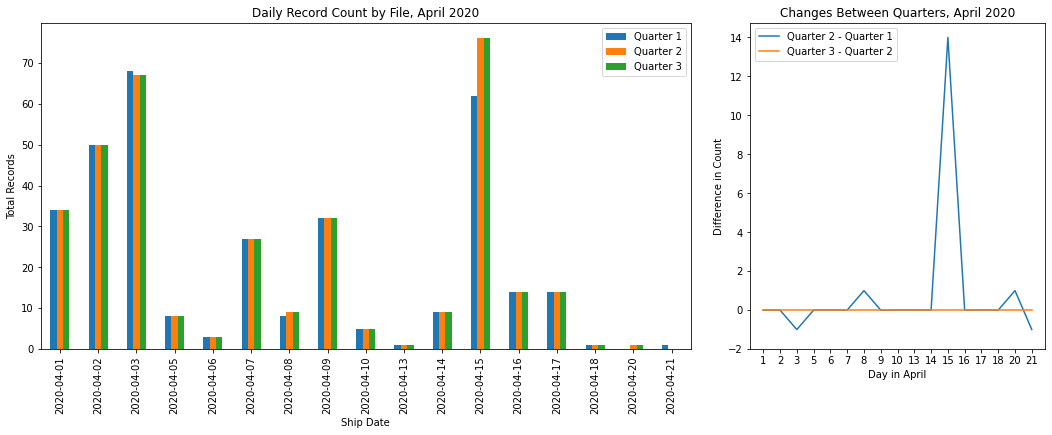

In [3]:
#    Explore the record counts for dates outside the expected quarter by file.
outside_quarter_start = '2020-04-01'
outside_quarter_end = '2020-04-21'

april_df = pd.DataFrame({
                    file_quarters_dict['transfers1'][1]: file_quarters_dict['transfers1'][0].\
                         loc[outside_quarter_start:outside_quarter_end].groupby('Ship Date')['Ship Date'].count(),
                    file_quarters_dict['transfers2'][1]: file_quarters_dict['transfers2'][0].\
                         loc[outside_quarter_start:outside_quarter_end].groupby('Ship Date')['Ship Date'].count(),
                    file_quarters_dict['transfers3'][1]: file_quarters_dict['transfers3'][0].\
                         loc[outside_quarter_start:outside_quarter_end].groupby('Ship Date')['Ship Date'].count()
                    }).fillna(0).astype(int)
april_df.index = april_df.index.to_period('d')

april_differences = april_df.diff(axis=1).iloc[:, 1:]
april_differences.columns = ['Quarter 2 - Quarter 1','Quarter 3 - Quarter 2']
april_differences[(april_differences['Quarter 2 - Quarter 1'] != 0) | 
                  (april_differences['Quarter 3 - Quarter 2'] != 0)]
april_differences.index = april_differences.index.day.astype(str)

#    Make a graph
fig = plt.figure(constrained_layout=False, figsize=(18,6))
gs1 = fig.add_gridspec(nrows=1, ncols=3)
fig_ax1 = fig.add_subplot(gs1[0,0:2])
fig_ax2 = fig.add_subplot(gs1[0,2:])
april_df.plot.bar(ax=fig_ax1,rot=90, legend=True, ylabel='Total Records',
                  title='Daily Record Count by File, April 2020')
april_differences.plot.line(ax=fig_ax2, legend=True,
                            xticks=(range(len(april_differences.index))), yticks=(range(-2,16,2)),
                            xlabel='Day in April',ylabel='Difference in Count',
                            title='Changes Between Quarters, April 2020')
plt.show()

Clearly, a given DLA LESO AllStatesAndTerritories file may have records that are more recent than the end of the published quarter. These records may or may not be consistant with the files in succeeding quarters.

### How many total records are there in each file?

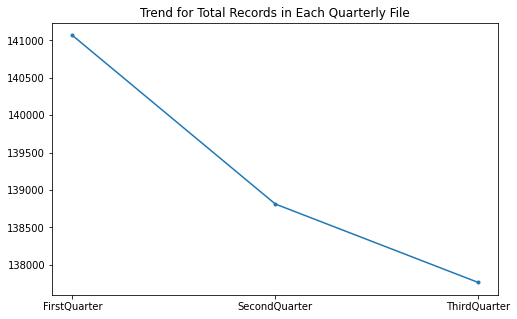

In [4]:
#    Explore total records in each file
ax = pd.Series({'FirstQuarter': file_quarters_dict['transfers1'][0].shape[0],
                'SecondQuarter': file_quarters_dict['transfers2'][0].shape[0],
                'ThirdQuarter': file_quarters_dict['transfers3'][0].shape[0]}).\
        plot(figsize=(8,5), xticks=(range(3)), style='.-',
             title="Trend for Total Records in Each Quarterly File")

In [5]:
#    Commentary
trans1_record_count = int(file_quarters_dict['transfers1'][0].shape[0])
trans2_record_count = int(file_quarters_dict['transfers2'][0].shape[0])
trans3_record_count = int(file_quarters_dict['transfers3'][0].shape[0])
print('Total records in the file from quarter 1:',trans1_record_count)
print('Total records in the file from quarter 2:',trans2_record_count)
print('Total records in the file from quarter 3:',trans3_record_count)

Total records in the file from quarter 1: 141068
Total records in the file from quarter 2: 138813
Total records in the file from quarter 3: 137764


The number of records, or DLA LESO items held by law enforcement agecies, is declining from file to file despite the growing time ranges and, presumably, requests for materials. Documentation at the [DLA LESO Public Data FAQ](https://www.dla.mil/DispositionServices/Offers/Reutilization/LawEnforcement/ProgramFAQs.aspx) states that *LESO Property Transferred to Participating Agencies* files are snapshots of the DLA LESO inventory of items held by law enforcement agencies at the end of a given quarter. It states that after 1 year, non-controlled items are removed from DLA LESO inventory and become the property of local law enforcement agencies.   

### How do the record counts from each file compare when split by controlled and non-controlled values?

There are two definitions found for controlled items. The definition at the DLA LESO Public Data website says [controlled](https://www.dla.mil/Portals/104/Documents/DispositionServices/LESO/DISP_ControlledPropertyDefinition_062019.pdf) items have a 'DEMIL Code' of B, C, D, E, F or G as well as those with a 'DEMIL Code' Q combined with a 'DEMIL IC' value of 3. The relevant U. S. code, [10 U.S.C. &sect; 2576a(f)](https://uscode.house.gov/view.xhtml?req=granuleid:USC-prelim-title10-section2576a&num=0&edition=prelim), defines controlled items as having a 'DEMIL Code' of B, C, D, E, G, and Q. For the purpose of this notebook, the first definition is used. Records that are not in the controlled group are considered non-controlled.   

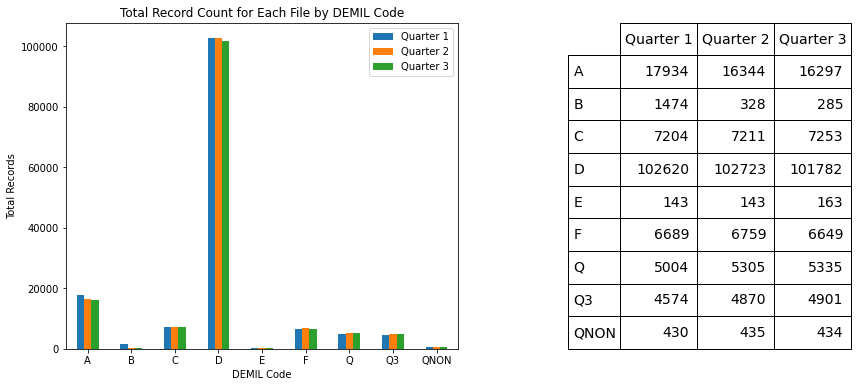

In [6]:
#    Explore record count when split by controlled/non-controlled values
get_Q_controlled = lambda x: x[(x['DEMIL Code'] == 'Q') & (x['DEMIL IC'] == 3)].groupby('DEMIL Code')['DEMIL Code'].count()
get_Q_noncontrolled = lambda x: x[(x['DEMIL Code'] == 'Q') & (x['DEMIL IC'] != 3)].groupby('DEMIL Code')['DEMIL Code'].count()

demilcode_qNON_count = pd.DataFrame([get_Q_noncontrolled(x[0]) for x in file_quarters_dict.values()]).T
demilcode_qNON_count.columns = ['Quarter 1', 'Quarter 2', 'Quarter 3']
demilcode_qNON_count.index = ['QNON']

demilcode_q3_count = pd.DataFrame([get_Q_controlled(x[0]) for x in file_quarters_dict.values()]).T
demilcode_q3_count.columns = ['Quarter 1', 'Quarter 2', 'Quarter 3']
demilcode_q3_count.index = ['Q3']

demilcode_count = pd.concat([x[0].groupby('DEMIL Code')['Ship Date'].count() for x in file_quarters_dict.values()], axis=1)
demilcode_count.columns = [x[1] for x in file_quarters_dict.values()]
demilcode_count = pd.concat([demilcode_count,demilcode_q3_count,demilcode_qNON_count])

#    Make a graph
fig = plt.figure(constrained_layout=False, figsize=(18,8))

gs1 = fig.add_gridspec(nrows=1, ncols=5)
fig_ax1 = fig.add_subplot(gs1[0,:3])
demilcode_count.plot.bar(ax=fig_ax1, rot=0, figsize=(12,6), legend=True, xlabel='DEMIL Code', ylabel='Total Records',
                  title='Total Record Count for Each File by DEMIL Code')

ax2 = fig.add_subplot(gs1[0,4])
font_size=14
bbox=[0, 0, 2, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = demilcode_count.values, rowLabels = demilcode_count.index,
                      bbox=bbox, colLabels=demilcode_count.columns, label='Actual Counts')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

In [7]:
#    Commentary
diff_t1t2all = trans1_record_count - trans2_record_count
t1nc = demilcode_count.loc[['A','QNON'], 'Quarter 1'].sum()
t2nc = demilcode_count.loc[['A','QNON'], 'Quarter 2'].sum()
diff_t1t2nc = t1nc - t2nc
t1c = demilcode_count.loc[['B','C','D','E','F','Q3'], 'Quarter 1'].sum()
t2c = demilcode_count.loc[['B','C','D','E','F','Q3'], 'Quarter 2'].sum()
diff_t1t2c = t1c - t2c

md(f"Focusing on the differences between Quarters 1 and 2,\
    there are {diff_t1t2all} more total records in the file from quarter 1 than from quarter 2. \
    Of these, {diff_t1t2nc} are non-controlled and {diff_t1t2c} are controlled. This means there are \
    {diff_t1t2c} records that have disappeared between the two files without explanation.")

Focusing on the differences between Quarters 1 and 2,    there are 2255 more total records in the file from quarter 1 than from quarter 2.     Of these, 1585 are non-controlled and 670 are controlled. This means there are     670 records that have disappeared between the two files without explanation.

### Are there patterens in the counts of controlled vs. non-controlled records since 2000?

In [8]:
#    Split into controlled/non-controlled dataframes for each file
controlled1, noncontrolled1 = split_demilcodes(file_quarters_dict['transfers1'][0])
controlled2, noncontrolled2 = split_demilcodes(file_quarters_dict['transfers2'][0])
controlled3, noncontrolled3 = split_demilcodes(file_quarters_dict['transfers3'][0])

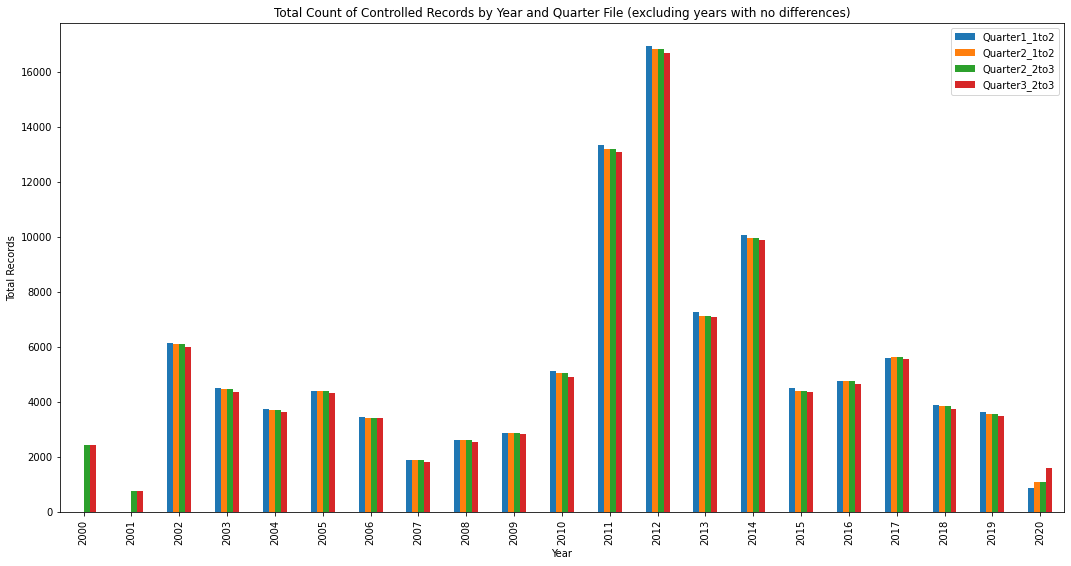

In [9]:
#    Explore patterns in controlled dataframes
between_t1c_and_t2c = differences_by_time('Y', '2000-01-01', '2020-09-30', controlled1, controlled2)
between_t2c_and_t3c = differences_by_time('Y', '2000-01-01', '2020-09-30', controlled2, controlled3)

compare_controlled = between_t1c_and_t2c.merge(between_t2c_and_t3c, how='outer',
                                               left_index=True, right_index=True, suffixes=['_first','_second'])
compare_controlled.columns = ['Quarter1_1to2','Quarter2_1to2','Quarter2_2to3','Quarter3_2to3']
compare_controlled = compare_controlled.fillna(0).astype(int)
compare_controlled.index = compare_controlled.index.to_period('y')

#    Make a graph
title_str = 'Total Count of Controlled Records by Year and Quarter File (excluding years with no differences)'
ax = compare_controlled.plot.bar(rot=90, figsize=(18,9), legend=True, xlabel='Year', ylabel='Total Records',
                                 title=title_str)

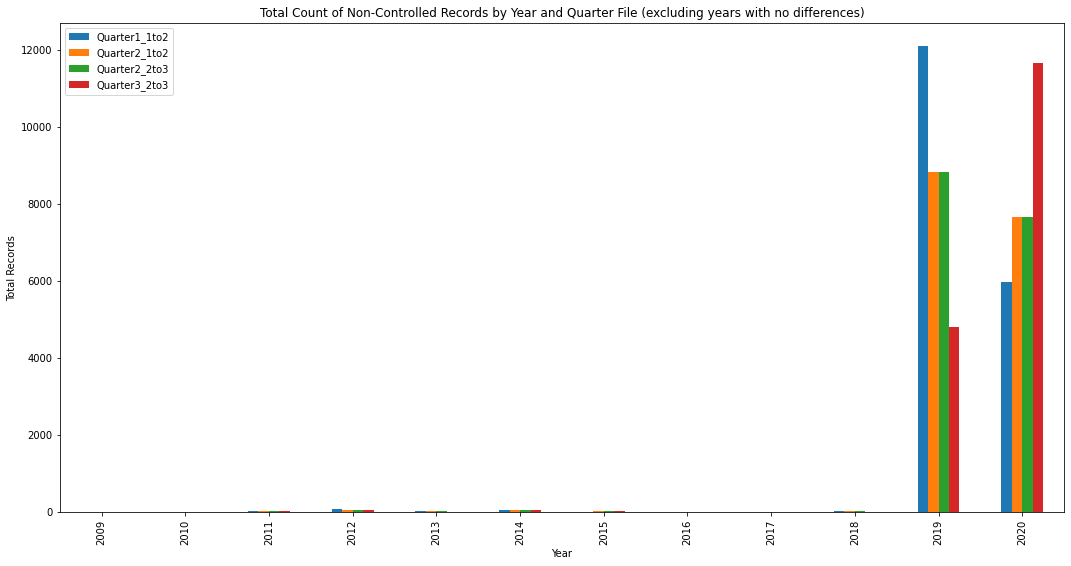

In [10]:
#    Explore patterns in controlled dataframes
between_t1nc_and_t2nc = differences_by_time('Y', '2000-01-01', '2020-09-30', noncontrolled1, noncontrolled2)
between_t2nc_and_t3nc = differences_by_time('Y', '2000-01-01', '2020-09-30', noncontrolled2, noncontrolled3)

compare_noncontrolled = between_t1nc_and_t2nc.merge(between_t2nc_and_t3nc, how='outer',
                          left_index=True, right_index=True, suffixes=['_first','_second'])
compare_noncontrolled.columns = ['Quarter1_1to2','Quarter2_1to2','Quarter2_2to3','Quarter3_2to3']
compare_noncontrolled = compare_noncontrolled.fillna(0).astype(int)
compare_noncontrolled.index = compare_noncontrolled.index.to_period('y')

#    Make a graph
title_str = 'Total Count of Non-Controlled Records by Year and Quarter File (excluding years with no differences)'
ax = compare_noncontrolled.plot.bar(rot=90, figsize=(18,9), legend=True, xlabel='Year', ylabel='Total Records',
                                    title=title_str)

As expected, 2019 shows a big decrease in non-controlled records. In each file, there is some change in both controlled and non-controlled records beyond one year ago. There is no documentation for why this happens. In an attempt to figure out why this is so, this repository merges the transfer data (DLA LESO AllStatesAndTerritories file) with request and cancellation data (DLA LESO Shipments_Cancellations files).

### Addendum: Exploring 2018 differences

Exploring the differences month-by-month in the year 2018 doesn't reveal patterns in which records are lost. It does show, however, that records are not only disappearing, but being added back in over time.

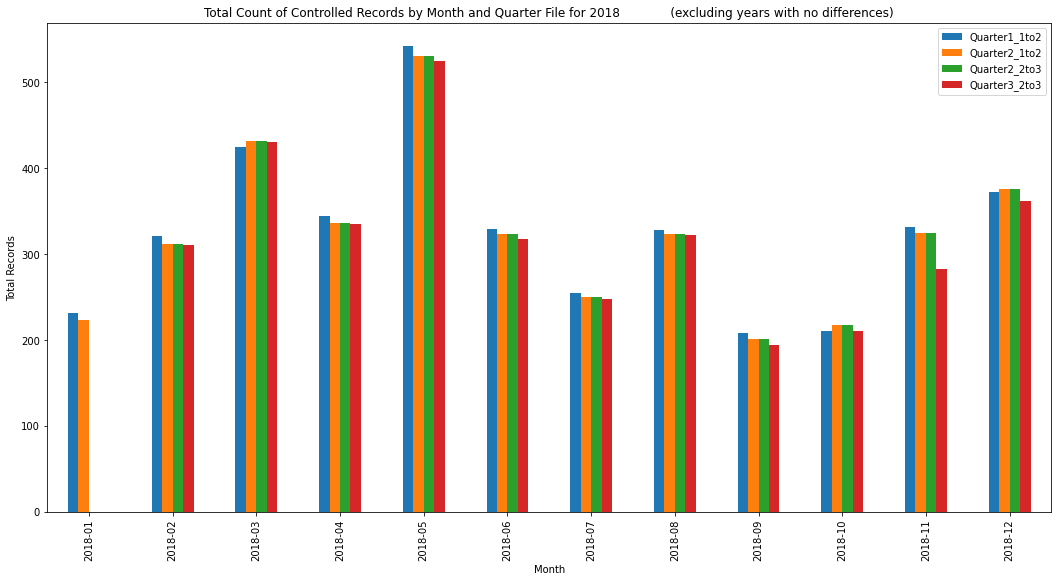

In [11]:
#    Explore patterns in controlled records of dataframes for 2018
month_between_t1c_and_t2c = differences_by_time('M', '2018-01-01', '2018-12-31', controlled1, controlled2)
month_between_t2c_and_t3c = differences_by_time('M', '2018-01-01', '2018-12-31', controlled2, controlled3)

month_compare_controlled = month_between_t1c_and_t2c.\
                                    merge(month_between_t2c_and_t3c, how='outer',
                                          left_index=True, right_index=True, suffixes=['_first','_second'])
month_compare_controlled.columns = ['Quarter1_1to2','Quarter2_1to2','Quarter2_2to3','Quarter3_2to3']
month_compare_controlled = month_compare_controlled.fillna(0).astype(int)
month_compare_controlled.index = month_compare_controlled.index.to_period('m')

#    Make a graph
title_str = 'Total Count of Controlled Records by Month and Quarter File for 2018 \
            (excluding years with no differences)'
ax = month_compare_controlled.plot.bar(rot=90, figsize=(18,9), legend=True,
                                       xlabel='Month', ylabel='Total Records',
                                       title=title_str)

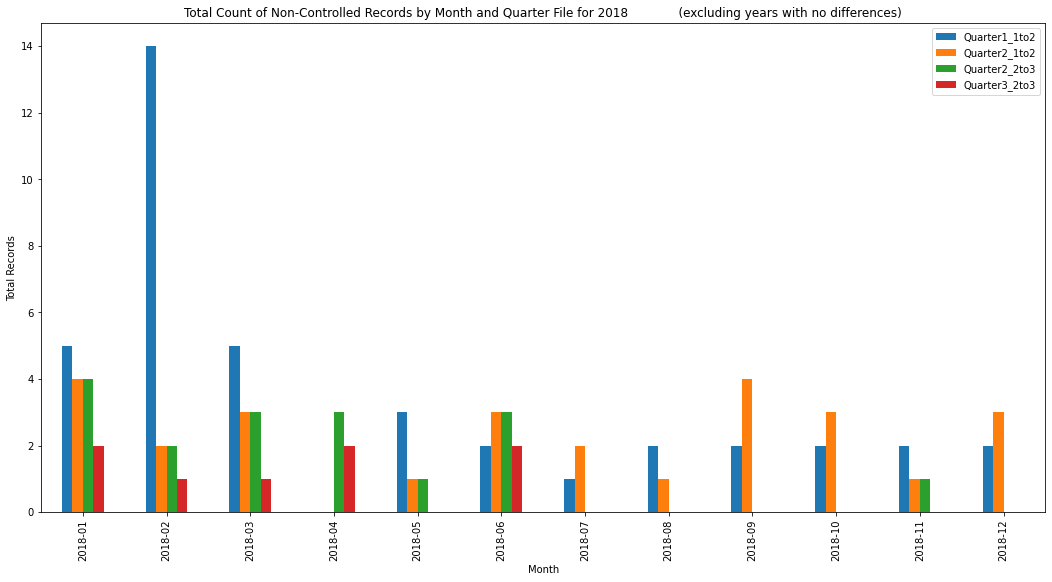

In [12]:
#    Explore patterns in non-controlled records of dataframes for 2018
month_between_t1nc_and_t2nc = differences_by_time('M', '2018-01-01', '2018-12-31', noncontrolled1, noncontrolled2)
month_between_t2nc_and_t3nc = differences_by_time('M', '2018-01-01', '2018-12-31', noncontrolled2, noncontrolled3)

month_compare_noncontrolled = month_between_t1nc_and_t2nc.\
                                    merge(month_between_t2nc_and_t3nc, how='outer',
                                          left_index=True, right_index=True, suffixes=['_first','_second'])
month_compare_noncontrolled.columns = ['Quarter1_1to2','Quarter2_1to2','Quarter2_2to3','Quarter3_2to3']
month_compare_noncontrolled = month_compare_noncontrolled.fillna(0).astype(int)
month_compare_noncontrolled.index = month_compare_noncontrolled.index.to_period('m')

#    Make a graph
title_str = 'Total Count of Non-Controlled Records by Month and Quarter File for 2018 \
            (excluding years with no differences)'
ax = month_compare_noncontrolled.plot.bar(rot=90, figsize=(18,9), legend=True,
                                          xlabel='Month', ylabel='Total Records',
                                          title=title_str)